In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# SECTION 1: <span style="color:red">Hash Rate Datasets</span>

In [2]:
## Directories
# Convention (H:HASH; P:POWER)
DR_H = 'Hash/'
DR_P = 'Power/'

## Read in unfiltered uncleaned datasets
# Convention (HR:HASH RATE; T:TOTAL; C:COUNTRY)
HR_T = pd.read_csv(DR_H+'H_Rate_Total.csv')
HR_C = pd.read_csv(DR_H+'H_Rate_Cntry.csv')

## Storing unfiltered datasets in frames
# Convention (DF:DataFrame)
HR_T_DF = pd.DataFrame(HR_T)
HR_C_DF = pd.DataFrame(HR_C)

## Combining Pool Hash Rates to Total Hash Rates [For Bitcoinity data]
#HR_T_DF['Total'] = 0
#for i in HR_T_DF.drop(['Time', 'Total'], axis=1):
#    HR_T_DF['Total'] += HR_T_DF[i].fillna(0.0)
#    HR_T_DF = HR_T_DF.drop([i], axis=1)

<b>HOURLY HASH RATE:</b> Path to hourly fluctuations<br>

Data for hourly fluctuations on BTC hashrate over all time is fairly expensive ($40).

The $40 dataset with hourly hash rate over all time is available below:
https://studio.glassnode.com/metrics?a=BTC&clid=00Q1I00000LtQY8UAN&ema=0&m=mining.HashRateMean&mAvg=90&mMedian=0&mScl=lin&pScl=lin&resolution=24h&utm_campaign=&utm_medium=firstmover&utm_source=newsletters&zoom=all

We could always purchase this dataset, but we are trying a free option for now.

Below is a method that assumes the fluctuation of hashing over the day is regular (i.e. hash rate hourly fluctuation for 11/20/21 is representative of hash rate hourly fluctuation for all other days)

In [3]:
## Hash Rate Variation Matrix (Hourly) [11/20/21; EH/s]
HR_VM = [145, 149, 152, 152, 149, 150, 149, 150, 156, 162, 168, 166, 159,
        158, 159, 167, 168, 164, 170, 172, 165, 162, 161, 159]
AVG = np.mean(HR_VM)

# Scaled Hash Rate Variation Matrix (to the average)
HR_VM_N = HR_VM/AVG

# Total Hash Rate Convolution with Variation Matrix [Hash Rate Total Hourly]
HR_T_H_L = []
for i in HR_T_DF['hash-rate']:
    HR_Conjunction = i*HR_VM_N
    HR_T_H_L.append(HR_Conjunction)
HR_T_H_L_Flat = np.array(HR_T_H_L).flatten().tolist()

# Total Hash Rate With Hourly Conjunction as DF
Time_Day_Hour = []
hours = [(dt.time(i).strftime('%I %p')) for i in range(24)]
for i in HR_T_DF['Timestamp']:
    Day = i.split(' ')[0]
    for j in hours:
        Time_Day_Hour.append(Day+' '+j)

HR_T_H_DF = pd.DataFrame(Time_Day_Hour, columns=['Timestamp'])
HR_T_H_DF['hash-rate'] = pd.DataFrame(HR_T_H_L_Flat)

## Filtering US monthly hashrate share of total hash rate from HR_C_DF
HR_C_DF_US = HR_C_DF[HR_C_DF['country'] == 'United States'].dropna()

<b>US Limited Hash Rate:</b> Limiting total global hash rate to US hash rate

In [4]:
## Information begins 2019-09 and ends 2021-08-01

# Let us assume pre 9/19: HR = 4.06%; post 8/21: HR = 35.4%
def Year_Month(df,ft):
    Yr_M_L = []
    for i in df[ft]:
        Year_Month = i.split(' ')[0].split('-')[0:2]
        Year_Month = Year_Month[0]+'-'+Year_Month[1]
        Yr_M_L.append(Year_Month)
    return Yr_M_L

Yr_M_L_T_H_DF = Year_Month(HR_T_H_DF, 'Timestamp')
HR_T_H_DF['Year-Month'] = Yr_M_L_T_H_DF

Yr_M_L_C_S_US = Year_Month(HR_C_DF_US, 'date')
HR_C_DF_US['Year-Month']= Yr_M_L_C_S_US

## Creating superset

# Year Month Hash Rate Share Map (Dictionary)
Yr_M_HR_Map = {}
HR_C_Index = HR_C_DF_US.index.tolist()
j = 0
for i in HR_C_DF_US['Year-Month']:
    Value = HR_C_DF_US['monthly_hashrate_%'][HR_C_Index[j]]
    Yr_M_HR_Map[i] = Value
    j +=1
Yr_M_HR_Map

# Including US share % from HR_C_DF_US in HR_T_H_DF
HR_T_H_DF['US_Share'] = 0
j = 0
for i in HR_T_H_DF['Year-Month']:
    if i not in HR_C_DF_US['Year-Month'].tolist():
        if i.split('-')[0] == '2018' or i.split('-')[0] == '2019':
            HR_T_H_DF['US_Share'][j] = HR_C_DF_US['monthly_hashrate_%'][0:1].tolist()[0]
        else:
            HR_T_H_DF['US_Share'][j] = HR_C_DF_US['monthly_hashrate_%'][-1:].tolist()[0]
    else:
        HR_T_H_DF['US_Share'][j] = Yr_M_HR_Map[i]
    j += 1

# Converting US share % to float
j = 0
for i in HR_T_H_DF['US_Share']:
    HR_T_H_DF['US_Share'][j] = float(i.strip('%'))/100
    j += 1

# Calculating US hash rate
HR_T_H_DF['US-hash-rate'] = HR_T_H_DF['hash-rate']*HR_T_H_DF['US_Share']

# Creating US hash rate unique data frame
HR_US_H_DF = HR_T_H_DF.drop(['hash-rate', 'Year-Month', 'US_Share'], axis=1)

/var/folders/xq/ck7x8bqd32z32tx5_84gzw8c0000gn/T/ipykernel_37014/1514567901.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HR_T_H_DF['US_Share'][j] = HR_C_DF_US['monthly_hashrate_%'][0:1].tolist()[0]
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[Text(0, 0, '0'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 150, '150'),
 Text(0, 200, '200')]

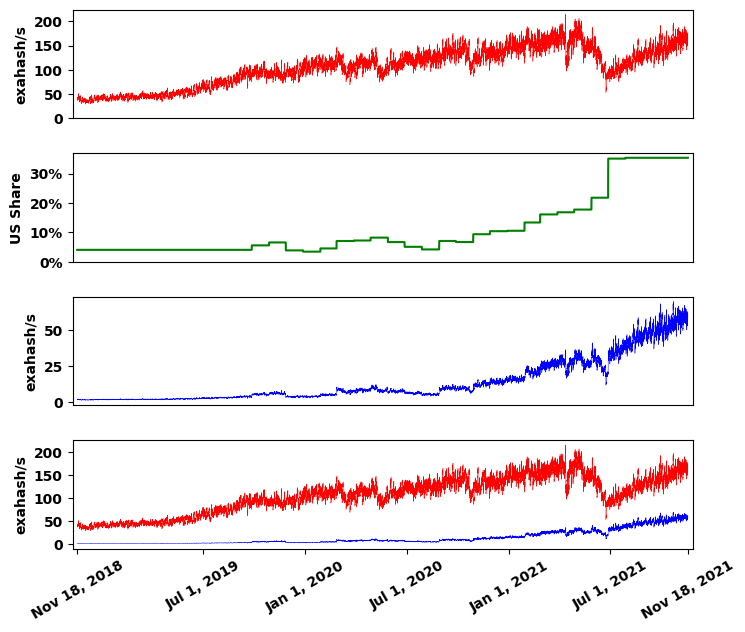

In [31]:
plt.rcParams.update(plt.rcParamsDefault)
fig = plt.figure(constrained_layout=False, figsize = (8,7))
#set constrained_layout=False and use wspace and hspace params to set amount of width/height reserved for space between subplots
gs = fig.add_gridspec(4,1, height_ratios = [1,1,1,1], hspace=.32)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
axlist = [ax1,ax2,ax3,ax4]
#lw = 6

x1 = HR_T_H_DF.index.tolist()
y1 = (HR_T_H_DF['hash-rate']/1000000).tolist()
y2 = (HR_T_H_DF['US-hash-rate']/1000000).tolist()
y3 = (HR_T_H_DF['US_Share']).tolist()

ax1.plot(x1, y1, c='r', linewidth=0.34)
ax2.plot(x1, y3, c='g')
ax3.plot(x1, y2, c='b', linewidth=0.34)
ax4.plot(x1, y1, c='r', linewidth=0.34)
ax4.plot(x1, y2, c='b', linewidth=0.34)
for a in range(3):
    axlist[a].set_xticks([])
    axlist[a].set_xticklabels([])
ax4.set_xticks([0,(181+44)*24,(365+44)*24,(365+182+44)*24,(365+366+44)*24,(365+366+181+44)*24,26279])
ax4.set_xticklabels(['Nov 18, 2018','Jul 1, 2019','Jan 1, 2020','Jul 1, 2020',\
                     'Jan 1, 2021','Jul 1, 2021','Nov 18, 2021'],rotation=30, fontweight='bold')
for a in range(4):
    axlist[a].set_xlim(-200,26479)
ax1.set_ylabel('exahash/s', fontweight='bold')
ax2.set_ylabel('US Share', fontweight='bold')
ax3.set_ylabel('exahash/s', fontweight='bold')
ax4.set_ylabel('exahash/s', fontweight='bold')
ax1.set_yticks([0,50,100,150,200])
ax1.set_yticklabels(['0','50','100','150','200'], fontweight='bold')
ax2.set_yticks([0,0.1,0.2,0.3])
ax2.set_yticklabels(['0%','10%','20%','30%'], fontweight='bold')
ax3.set_yticks([0,25,50])
ax3.set_yticklabels(['0','25','50'], fontweight='bold')
ax4.set_yticks([0,50,100,150,200])
ax4.set_yticklabels(['0','50','100','150','200'], fontweight='bold')

#ax7.plot([],[],color='m', label='Battery', linewidth=lw,alpha=1)
#ax7.plot([],[],color='orange', label='Solar', linewidth=lw,alpha=1)
#ax7.plot([],[],color='c', label='Wind', linewidth=lw,alpha=1)
#ax7.plot([],[],color='b', label='Hydro', linewidth=lw,alpha=1)
#ax7.plot([],[],color='r', label='Fossil', linewidth=lw,alpha=1)
#ax7.plot([],[],color='g', label='Imports', linewidth=lw,alpha=1)
#ax7.plot([],[],color='grey', label='Must run', linewidth=lw,alpha=1)
#ax7.legend(loc='center', bbox_to_anchor=(.5,-0.55), ncol=4, prop=dict(weight='bold', size=16))

#plt.savefig('Hash_Rate_Tote', dpi=160, transparent=False)

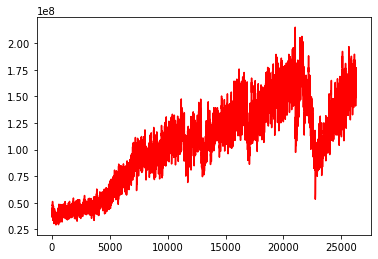

In [405]:
plt.plot(x1,y1,c='r')

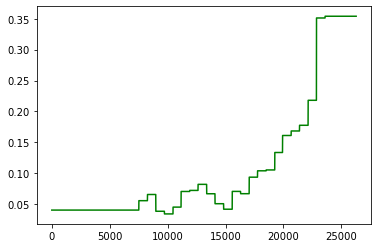

In [406]:
plt.plot(x1,y3,c='g')

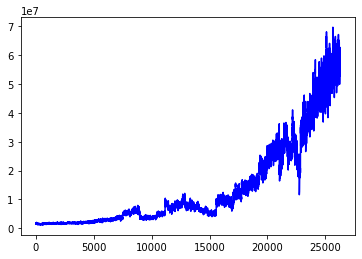

In [407]:
plt.plot(x1,y2,c='b')

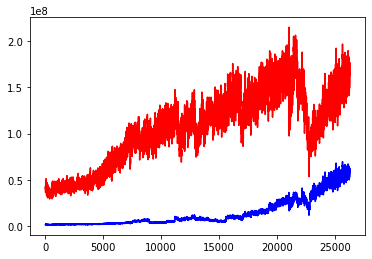

In [408]:
plt.plot(x1,y1,c='r')
plt.plot(x1,y2,c='b')

# THIS INFO FOR LAST 3 YEARS